# Programming and Visualizing Random Forest Model from Scracth (NOT using SKLearn)

## *A personal project by AJ Beiza showcasing model creation, model testing, and mathematics*

In [37]:
# importing required libraries
from sklearn.datasets import load_iris
import numpy as np
import math
import random
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier as SKLearnRandomForest
from sklearn.metrics import accuracy_score
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()

# Decision Trees

### Decision Trees are the backbone of Random Forest (a Random Forest is an 'ensemble' model made up of decision trees). To understand Random Forest, it is CRUCIAL to understand Decision Trees. To be best prepared, it is also good to have background knowledge of object oriented programming as well as tree data structures (specifically binary trees).

### To build a tree, we need a class for the actual nodes of the trees. Decision Trees nodes can either be decision nodes (that ask a question like "is x>4?" or "is y<=9?") or leaf nodes that say what class a datapoint belongs. All paths of the decision tree should end on a leaf node (a decision tree CANNOT end on a decision tree, think about why)

In [41]:
class Node():

    def __init__(self, feature_index=None, threshold=None, left_node=None, right_node=None, info_gained=None, value=None, classes=None):

        # necessary attributes for a decision node
        
        self.feature_index = feature_index # stores the index of the feature that threshold will use to compare (ie x in "is x>4?")
        self.threshold = threshold # stores value that training data will be split upon (ie 4 in "is x>4?")
        self.left_node = left_node # points to left child
        self.right_node = right_node # points to right child
        self.info_gained = info_gained # stores the information gain of a split in a decision tree

        # necessary attributes for a leaf node
        
        self.value = value # stores value of class that a datapoint belongs to
        self.classes = classes #used for predict_proba method

In [43]:
class DecisionTreeClassifier():

    # constructor for Decision Tree
    def __init__(self, min_samples_split=2, max_depth=4):

        # root will be used to traverse decision tree when building tree and predicting from it
        self.root = None

        self.classes_ = None # used in predict_proba method

        # stopping conditions for build_tree
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, current_depth=0):


        X = dataset[:,:-1] # get all rows and all columns except the last one, which will be the column to classify
        y = dataset[:,-1] # get all entries of last column 

        num_samples, num_features = np.shape(X)

        # if either of these conditions is not met, the node returned will be a leaf node
        if num_samples >= self.min_samples_split and current_depth <= self.max_depth:

            best_split = self.get_best_split(dataset, num_samples, num_features)

            if "info_gained" in best_split and best_split["info_gained"] > 0:

                # recursively build left tree and right tree until sample is too small or depth is too high
                left_tree = self.build_tree(best_split["less_than"], current_depth+1)
                right_tree = self.build_tree(best_split["greater_than"], current_depth+1)
    
                return Node(best_split["feature_index"], best_split["threshold"], left_tree, right_tree, best_split["info_gained"])

        # else return a leaf node when data is pure
        leaf_node_value = self.calculate_leaf_node_value(y)
        return Node(value=leaf_node_value, classes=y)

    
    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gained = -float("inf") #instantiating at -inf because every value is greater than -inf

        # iteratively check every value of every feature as a candidate to be a split for decision node
        for feature_idx in range(num_features):

            possible_thresholds = np.unique(dataset[:, feature_idx]) # get unique list of feature values that can be used to split data into left and right node
            for threshold in possible_thresholds:

                # filter dataset based on category
                less_than = dataset[dataset[:, feature_idx] <= threshold] 
                greater_than = dataset[dataset[:, feature_idx] > threshold]

                # the threshold must split the data so that there is data above and below threshold, otherwise the split did nothing
                if len(less_than) > 0 and len(greater_than) > 0:

                    # extracting the class label column for each dataset
                    y = dataset[:,-1]
                    y_less_than = less_than[:,-1] 
                    y_greater_than = greater_than[:,-1]

                    # calculating the amount of information gained, we are trying to maximize it
                    info_gained = self.info_gained(y, y_less_than, y_greater_than)

                    if info_gained > max_info_gained:

                        # set new max info gained
                        best_split["feature_index"] = feature_idx
                        best_split["threshold"] = threshold
                        best_split["less_than"] = less_than
                        best_split["greater_than"] = greater_than
                        best_split["info_gained"] = info_gained
                        max_info_gained = info_gained
                        
        return best_split


    def info_gained(self, y, y_less_than, y_greater_than, mode="entropy"):

        class_labels = np.unique(y) 

        weight_less_than = len(y_less_than) / len(y)
        weight_greater_than = len(y_greater_than) / len(y)

        #calculates info gained
        info_gained = self.entropy(y) - (weight_less_than * self.entropy(y_less_than) + weight_greater_than * self.entropy(y_greater_than))

        return info_gained

    def entropy(self, y):

        class_labels = np.unique(y) # gets a list of possible classes 
        entropy = 0

        for class_label in class_labels:

            prob_of_class = np.count_nonzero(y == class_label) / len(y) # calculates probability that an element of y is the certain class
            entropy += -1*prob_of_class*np.log2(prob_of_class) # calculates entropy

        return entropy

    def calculate_leaf_node_value(self, y):

        '''Find most common Y value to be the leaf node value'''

        y = list(y)
        return max(y, key=y.count)

    def fit(self, X, y, ax=None):

        data = np.concatenate((X,np.array([[entry] for entry in y])), axis=1)
        self.classes_ = np.unique(y) # stores all classes for use in predict_proba
        
        if ax is not None:
            self.root = self.build_tree(data, ax=ax)
        else:
            self.root = self.build_tree(data)

    def make_prediction(self, X, node):

        '''Get prediction for 1d array. Traverses through tree to find class that entry fits'''
        
        while node.value is None: # while we are on a decision node

            feature_value = X[node.feature_index] # only focus on feature of X that node analyzes

            if feature_value <= node.threshold:

                node = node.left_node
                
            else:
                
                node = node.right_node

        return node.value
        
    def predict(self, X):

        '''get multiple predictions for 2d array'''


        return np.array([self.make_prediction(row, self.root) for row in X])

    def predict_proba(self, X):

        probabilities_list = []

        for row in X:  # Loop over each sample (row) in X
            node = self.root  # Start at the root for each sample
    
            # Traverse the tree to a leaf node
            while node.value is None:
                feature_value = row[node.feature_index]  # Current feature value
                if feature_value <= node.threshold:
                    node = node.left_node
                else:
                    node = node.right_node
    
            # now at the leaf node, calculate probabilities of each class
            total_samples = len(node.classes)
            probabilities = []
    
            for class_label in self.classes_:
                class_count = np.count_nonzero(node.classes == class_label)
                prob = class_count / total_samples
                probabilities.append(prob)
    
            probabilities_list.append(probabilities)

        return np.array(probabilities_list)
        

In [45]:
dt_model = DecisionTreeClassifier(max_depth=1)
dt_model.fit(iris.data, iris.target)
print(f"Predicted class: {dt_model.predict(np.array([[6.2,2.5,5.9,4.4]]))}")
print(f"Predicted class probabilities: {dt_model.predict_proba(np.array([[6.2,2.5,5.9,4.4]]))}")

Predicted class: [2.]
Predicted class probabilities: [[0.         0.02173913 0.97826087]]


In [47]:
class RandomForestClassifier():

    def __init__(self, num_trees=100, min_samples_split=2,max_depth=4, max_features='sqrt'):

        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.base_learners = [] #holds list of decision tree objects
        self.min_samples_split = min_samples_split

    def bootstrap(self, dataset):

        """
        Makes a boostrapped dataset to train decision tree on. Bootstrapping data in an ensemble model introduces 
        randomness to avoid overfitting
        """

        bootstrapped_dataset = []

        for _ in range(len(dataset)):

            # grabs random row index from dataset
            random_row_idx = np.random.randint(0, len(dataset))
            bootstrapped_dataset.append(dataset[random_row_idx])

        return np.array(bootstrapped_dataset)

    def fit(self, dataset_features, dataset_targets):

        # finding the number of features to use to train decision trees
        if self.max_features == "sqrt":
            max_features = int(math.pow(len(dataset_features[0]), 0.5))
        elif self.max_features == "log2":
            max_features = int(math.log2(len(dataset_features[0])))
        else:
            max_features = self.max_features

        # check if max_features is greater than the number of features in dataset
        if max_features > dataset_features.shape[1]:
            raise ValueError(f"max_features ({max_features}) cannot be greater than the number of features in dataset({dataset_features.shape[1]})")
            
        # training base learners
        for _ in range(self.num_trees):

            # get a bootstrapped dataset
            bootstrapped_dataset = self.bootstrap(np.column_stack((dataset_features, dataset_targets)))
            training_dataset_x = bootstrapped_dataset[:, :-1]
            training_dataset_y = bootstrapped_dataset[:, -1]

            # get random max_features amount of features to train the model
            random_features = np.array(random.sample(range(len(dataset_features[0])), max_features))
            training_dataset_x = training_dataset_x[:, random_features]

            # instantiate and fit new decision tree model
            decision_tree = DecisionTreeClassifier(self.min_samples_split, self.max_depth)
            decision_tree.fit(training_dataset_x, training_dataset_y)

            # add the trained decision tree to the list of base_learners along with the features used to train it
            self.base_learners.append((decision_tree, random_features))

    def make_prediction(self, X):

        '''Get prediction for 1d array. Returns the most common predicted class from the decision tree base learners'''

        predicted_classes = [] # stores the predicted class from each decision tree

        for decision_tree, random_features in self.base_learners:

            # filter X to only include features that the decision tree was trained on 
            X_filtered = X[random_features]

            # print_tree(decision_tree.root)

            # get prediction of decision tree
            predicted_class = decision_tree.make_prediction(X_filtered, decision_tree.root)

            # append predicted class to predicted classes
            predicted_classes.append(predicted_class)


        # Majority voting for classification
        return Counter(predicted_classes).most_common(1)[0][0]

    def predict(self, X):

        return np.array([self.make_prediction(x) for x in X])


## Testing my Random Forest Classification Model using K-Fold Cross Validation

In [50]:
def k_fold_cross_validation(X, y, model, k=5):
    # Shuffle data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Split indices into k folds
    folds = np.array_split(indices, k)
    
    accuracies = []
    
    for i in range(k):
        # Create train and test sets
        test_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
        
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        # Initialize and train the model
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return round(np.mean(np.array(accuracies)),2)

iris = load_iris()
X = iris.data
y = iris.target

rf_model = RandomForestClassifier(num_trees=15, max_features=4)
print(f"Mean Cross-Validation Accuracy of My Implementation: {k_fold_cross_validation(X, y, rf_model, k=5)}")

Mean Cross-Validation Accuracy of My Implementation: 0.97


## Testing SKLearn's Random Forest Classification Model using K-Fold Cross Validation

In [53]:
# instantiate SK Learn's implementation of Random Forest Model
rf_model = SKLearnRandomForest(n_estimators=15, max_features=4)  # instantiating with same parameters as my random forest model

# define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True)  # 5-fold cross-validation

# Perform cross-validation and compute accuracy scores
cross_val_scores = cross_val_score(rf_model, iris.data, iris.target, cv=kf, scoring='accuracy')

# Print the cross-validation scores and their mean
print(f"Mean Cross-Validation Accuracy of SK-Learn's Implementation: {np.mean(cross_val_scores):.2f}")

Mean Cross-Validation Accuracy of SK-Learn's Implementation: 0.97


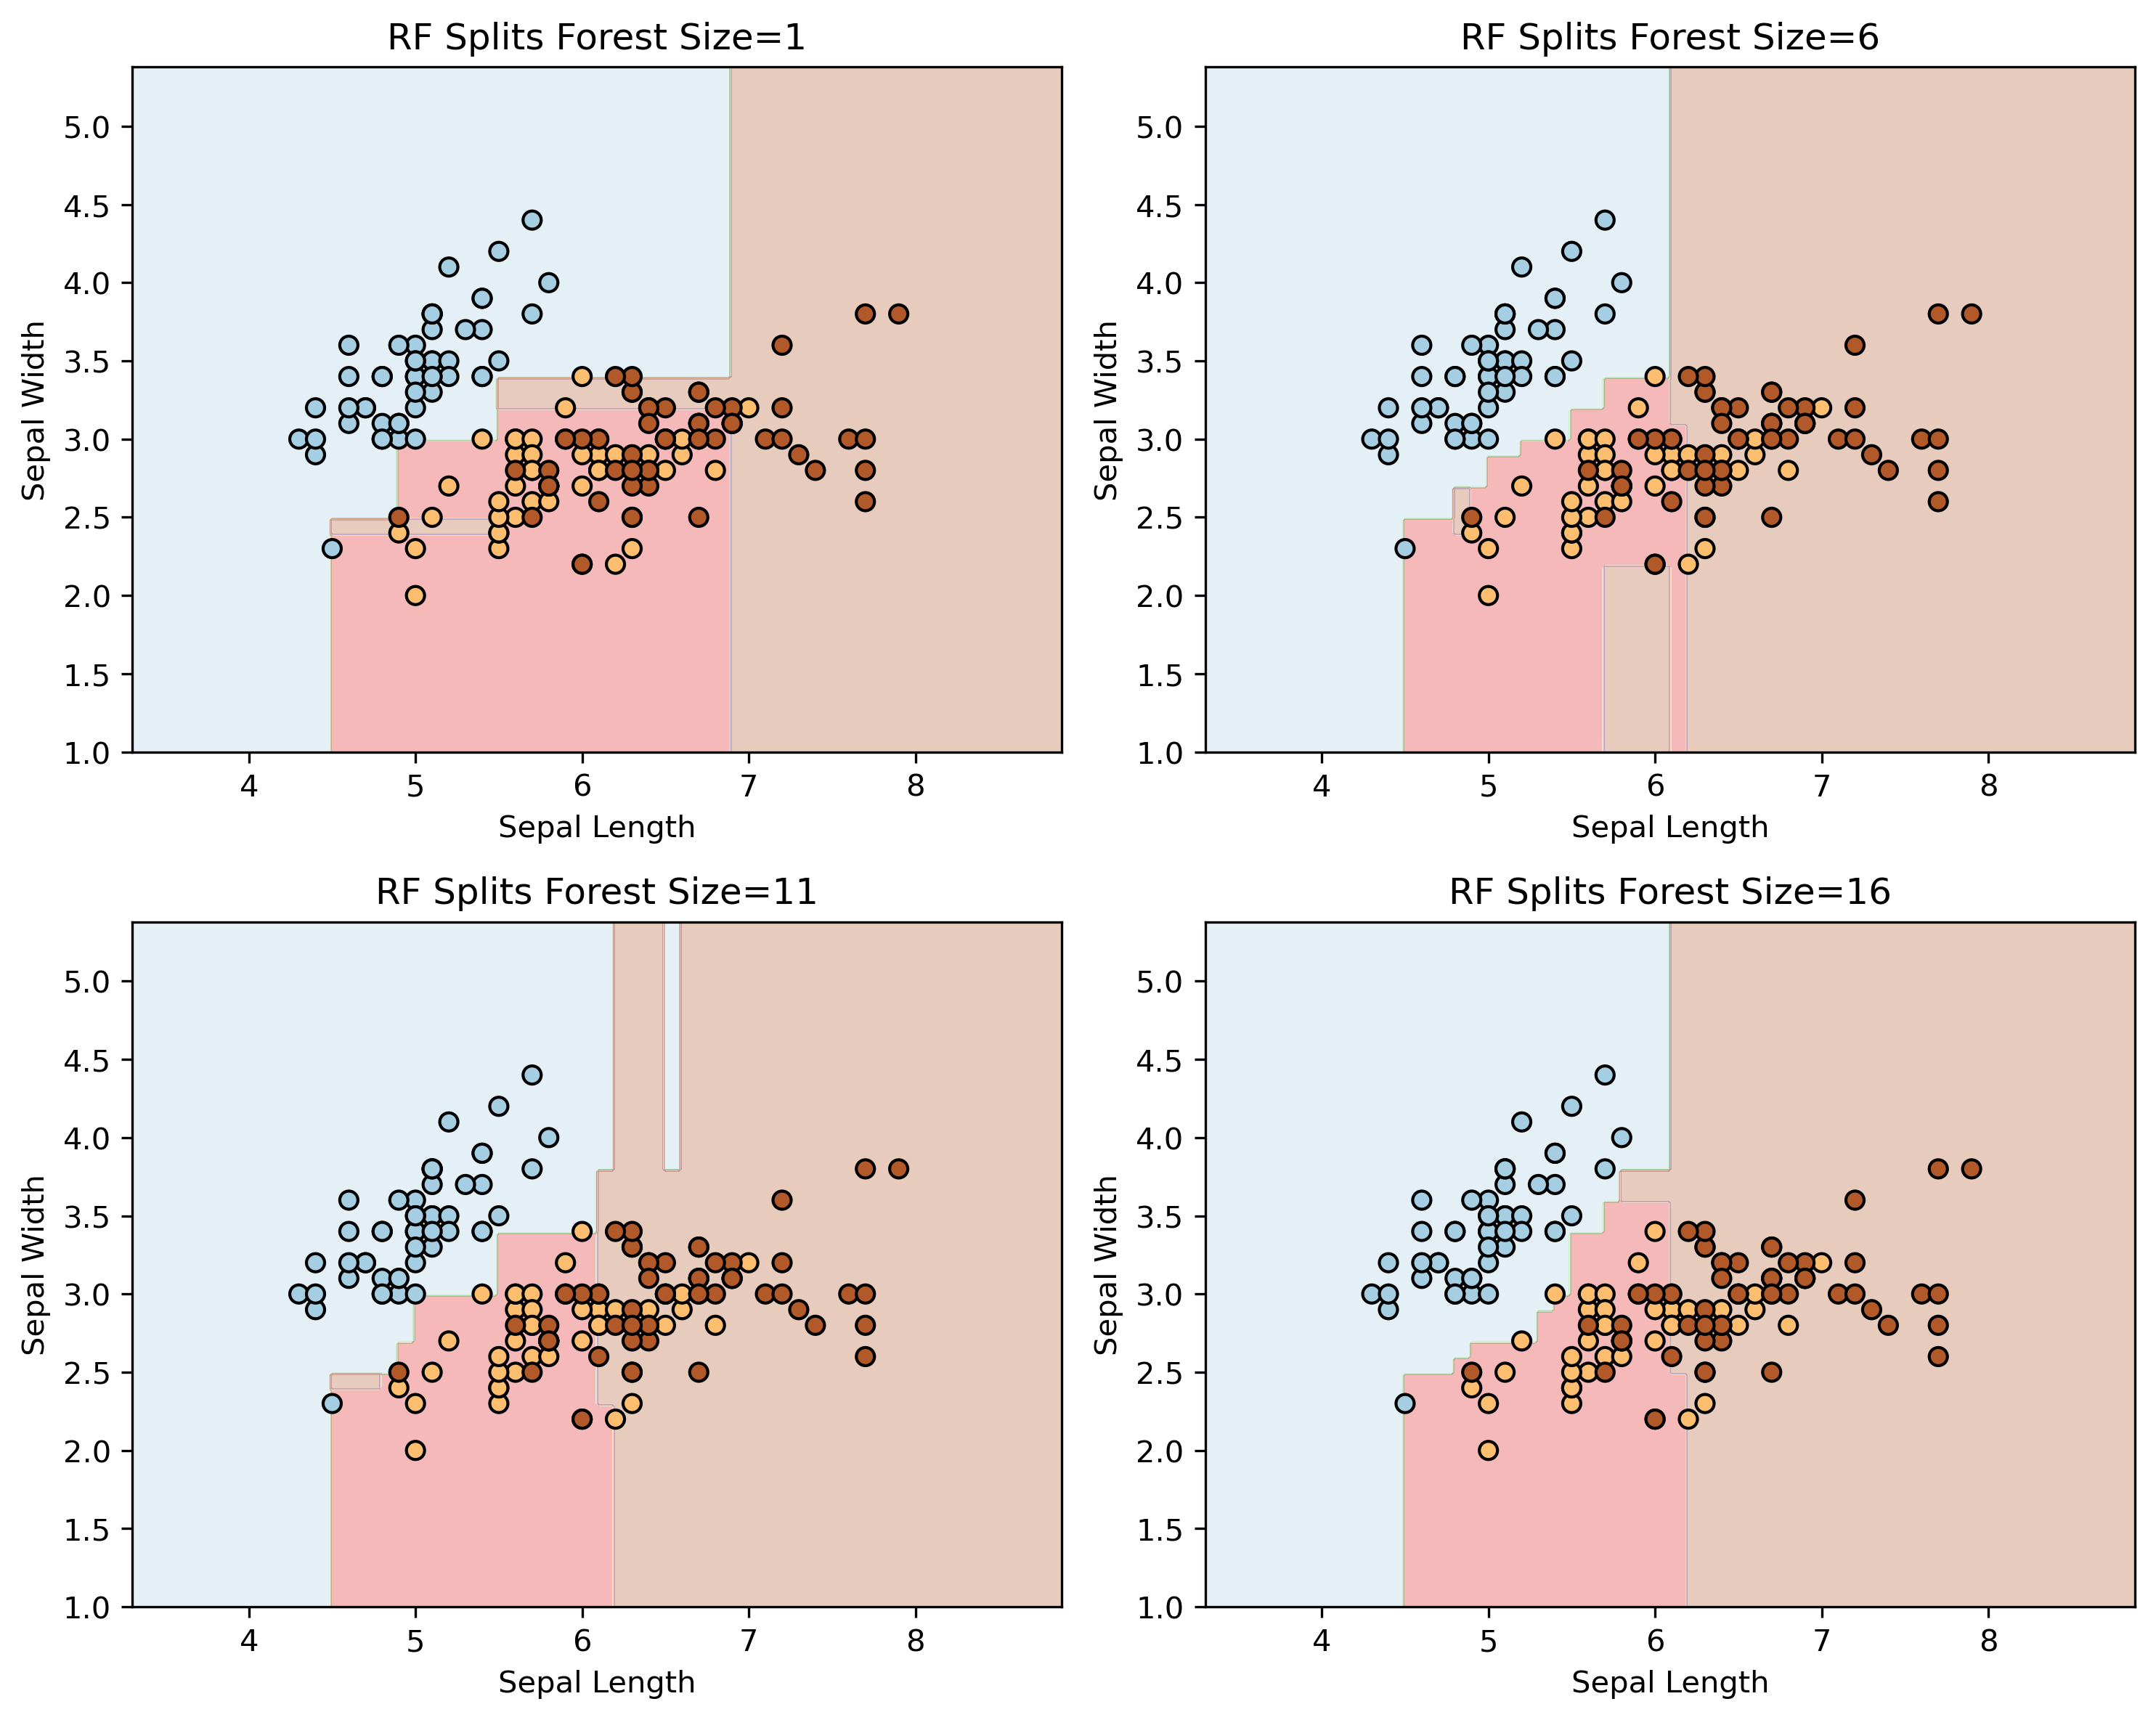

In [34]:
# Function to plot decision boundaries
def plot_decision_boundaries(clf, X, y, ax, title="Decision Boundaries"):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot decision boundaries and scatter points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(title)
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')

# Set up the plot
dpi = 300
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=dpi)

forest_size_range = range(1,20,5)  # number of base learners
for size, ax in zip(forest_size_range, axes.flatten()):
    clf = RandomForestClassifier(num_trees=size, max_depth=3, max_features=2)
    clf.fit(iris.data[:, :2], iris.target)
    plot_decision_boundaries(clf, X, y, ax, f"RF Splits Forest Size={size}")

plt.tight_layout()
plt.savefig("decision_boundaries_rf.png", dpi=dpi)
plt.show()

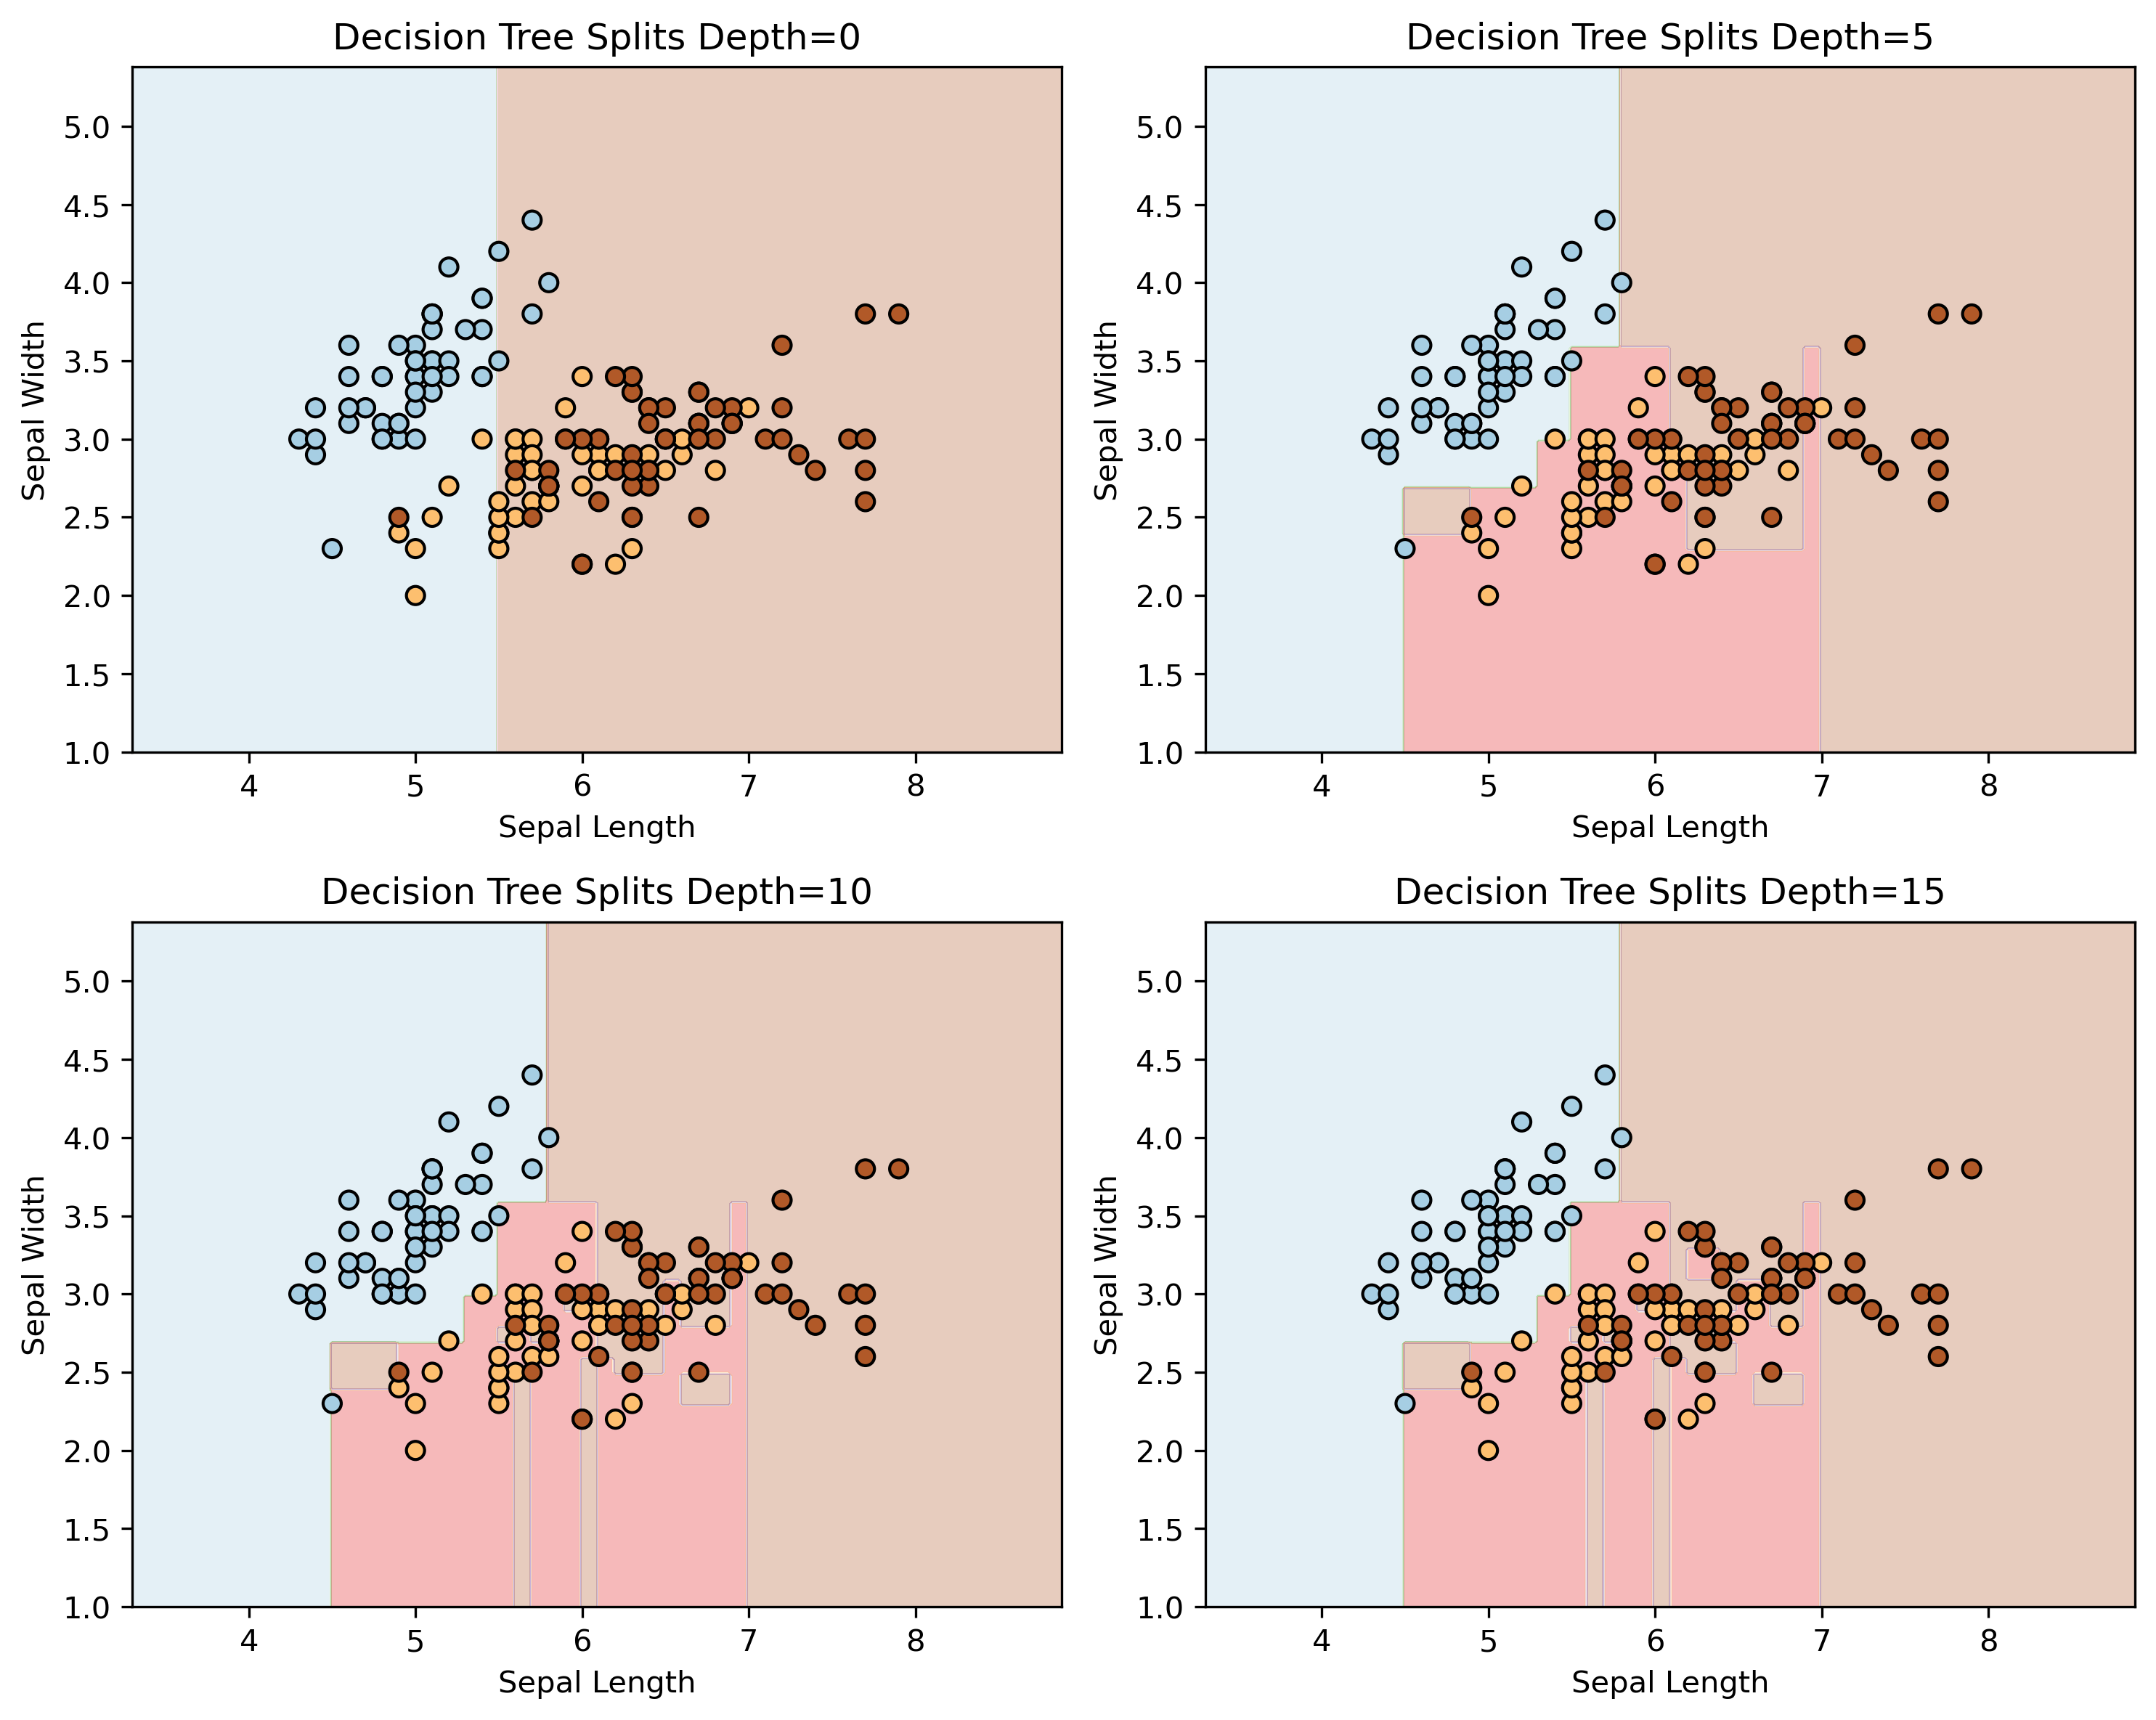

In [75]:
# Function to plot decision boundaries

X = iris.data[:, :2]  # use only the first two features for 2D plotting
y = iris.target

def plot_decision_boundaries_dt(clf, X, y, ax, title="Decision Boundaries"):
    # Create a mesh grid based on feature ranges
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plot decision boundaries and scatter points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(title)
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')

# Set up the plot
dpi = 300
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=dpi)

depth_range = range(0, 20, 5)  # depths from 1 to 4
for depth, ax in zip(depth_range, axes.flatten()):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, y)
    plot_decision_boundaries_dt(clf, X, y, ax, f"Decision Tree Splits Depth={depth}")

plt.tight_layout()
plt.savefig("decision_boundaries.png", dpi=dpi)
plt.show()